<a href="https://colab.research.google.com/github/Amithashreshta/255/blob/main/CMPE_255_Term_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





#  Exploratory Data Analysis and Data pre processing

In [ ]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import io
from scipy.stats import boxcox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/'

MyDrive  Shareddrives


In [ ]:
df = pd.read_csv('/content/drive/My Drive/US_Accidents_June20.csv')
print("The shape of data is:",(df.shape))
df.head()

The shape of data is: (3513617, 49)


,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day



###  Sources and plots based on the duration i.e the start time and end time
    

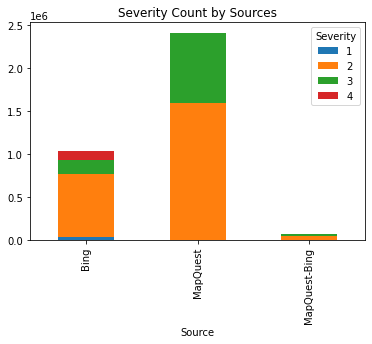

In [ ]:
## Plot of sources and their grouping with respect to severity
df_source = df.groupby(['Severity','Source']).size().reset_index().pivot(\
    columns='Severity', index='Source', values=0)
df_source.plot(kind='bar', stacked=True, title='Severity Count by Sources')

In [ ]:
# fix datetime type 
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])

# calculate duration as the difference between end time and start time in minute
df['Duration'] = df.End_Time - df.Start_Time 
df['Duration'] = df['Duration'].apply(lambda x:round(x.total_seconds() / 60) )
print("The overall mean duration is: ", (round(df['Duration'].mean(),3)), 'min')

The overall mean duration is:  115.404 min


In [ ]:
## MapQuest is being considered as maximum share of information is obtained from it
df = df.loc[df['Source']=="MapQuest",]
df = df.drop(['Source'], axis=1)

In [ ]:
## drop the categorical features after observing the unique values
df = df.drop(['ID','TMC','Description','Distance(mi)', 'End_Time', 'Duration', 
              'End_Lat', 'End_Lng','Country','Turning_Loop'], axis=1)






### Wind Direction and Weather Conditions

In [ ]:
## observing the various types of wind_direction
print("Wind Direction: ", df['Wind_Direction'].unique())

Wind Direction:  ['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']


In [ ]:
## cleaning up the various and encoding them to one type
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['CALM' 'SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' nan]


In [ ]:
# show distinctive weather conditions 
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drizzle', 'Dust', 'Dust Whirlwinds', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Smoke', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Hail', 'Light Haze', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Grains', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorm', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Showers', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Volcanic Ash', 'Widespr

In [ ]:
## encoding the various weather conditions into 0 and 1
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear', case=False, na = False), 1, 0)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), 1, 0)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|storm', case=False, na = False), 1, 0)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), 1, 0)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), 1, 0)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), 1, 0)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog', case=False, na = False), 1, 0)

# Assign NA to created weather features where 'Weather_Condition' is null.
weather = ['Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog']
for i in weather:
  df.loc[df['Weather_Condition'].isnull(),i] = df.loc[df['Weather_Condition'].isnull(),'Weather_Condition']

df.loc[:,['Weather_Condition'] + weather]

df = df.drop(['Weather_Condition'], axis=1)

In [ ]:
df

,Severity,Start_Time,Start_Lat,Start_Lng,Number,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog
0,3,2016-02-08 05:46:00,39.865147,-84.058723,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,CALM,NaN,0.02,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0
1,2,2016-02-08 06:07:59,39.928059,-82.831184,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,CALM,NaN,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,0,0,1,0,0,0,0
2,2,2016-02-08 06:49:27,39.063148,-84.032608,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,False,False,False,False,False,False,False,False,False,False,False,True,Night,Night,Day,Day,0,1,0,0,0,0,0
3,3,2016-02-08 07:23:34,39.747753,-84.205582,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,1,0,0,0,0,0
4,2,2016-02-08 07:39:07,39.627781,-84.188354,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,False,False,False,False,False,False,False,False,False,False,False,True,Day,Day,Day,Day,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478813,3,2017-08-30 18:41:30,34.495808,-118.623932,NaN,Lake Hughes Rd,R,Castaic,Los Angeles,CA,91384,US/Pacific,K3A6,2017-08-30 18:51:00,100.0,100.0,18.0,28.85,10.0,W,5.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,0,0,0,0,0
2478814,3,2017-08-30 18:59:02,34.031322,-118.433723,NaN,I-10 W,R,Los Angeles,Los Angeles,CA,90064,US/Pacific,KSMO,2017-08-30 18:51:00,77.0,NaN,64.0,29.69,10.0,S,5.8,NaN,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,1,0,0,0,0,0,0
2478815,3,2017-08-30 18:57:52,34.106785,-117.369102,119.0,E Foothill Blvd,L,Rialto,San Bernardino,CA,92376-5157,US/Pacific,KSBD,2017-08-30 18:50:00,102.2,NaN,16.0,29.73,6.0,S,5.8,NaN,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,0,0,0,0,0
2478816,3,2017-08-30 19:49:01,33.924686,-118.103981,NaN,Manchester Ave,R,Norwalk,Los Angeles,CA,90650,US/Pacific,KFUL,2017-08-30 19:53:00,88.0,NaN,39.0,29.68,10.0,W,3.5,NaN,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day,1,0,0,0,0,0,0



###  Fix Datetime Format : 
###The start time stamp is mapped to various featurs such as minute, hour, week etc and they are made as seperate attributes.

In [ ]:
# average difference between weather time and start time
print("Mean difference between 'Start_Time' and 'Weather_Timestamp': ", 
(df.Weather_Timestamp - df.Start_Time).mean())

Mean difference between 'Start_Time' and 'Weather_Timestamp':  0 days 00:00:30.397947930


In [ ]:
## dropping the weather_timestamp as it is not that different from the start duration and creating the hour,day, weekday,month,  into new attributes.
df = df.drop(["Weather_Timestamp"], axis=1)

df['Year'] = df['Start_Time'].dt.year

nmonth = df['Start_Time'].dt.month
df['Month'] = nmonth

df['Weekday']= df['Start_Time'].dt.weekday

days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday

df['Hour'] = df['Start_Time'].dt.hour

df['Minute']=df['Hour']*60.0+df["Start_Time"].dt.minute

df.loc[:4,['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']]

,Start_Time,Year,Month,Weekday,Day,Hour,Minute
0,2016-02-08 05:46:00,2016,2,0,39,5,346.0
1,2016-02-08 06:07:59,2016,2,0,39,6,367.0
2,2016-02-08 06:49:27,2016,2,0,39,6,409.0
3,2016-02-08 07:23:34,2016,2,0,39,7,443.0
4,2016-02-08 07:39:07,2016,2,0,39,7,459.0



##  Handling Missing Data



In [ ]:
## calculating the the percentage of null values in the various features
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / df.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)
4,Number,59.879195
7,City,0.002071
10,Zipcode,0.012840
11,Timezone,0.085366
12,Airport_Code,0.170857
13,Temperature(F),1.634138
14,Wind_Chill(F),58.718072
15,Humidity(%),1.742119
16,Pressure(in),1.404009
17,Visibility(mi),1.969680


More than 59.87% percent of 'Number', 'Wind_Chill(F)', and 'Precipitation(in)' is missing. Drop na and value imputation wouldn't work for these features. 'Number' and 'Wind_Chill(F)' will be dropped because they are not highly related to severity according to previous research, whereas 'Precipitation(in)' could be a useful predictor and hence can be handled by separating feature.

Drop these features:

 1. 'Number'

 2. 'Wind_Chill(F)'


In [ ]:
df = df.drop(['Number','Wind_Chill(F)'], axis=1)

In [ ]:
## precipitation is added as another feature and median imputation is performed on it
df['Precipitation_NA'] = 0
df.loc[df['Precipitation(in)'].isnull(),'Precipitation_NA'] = 1
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
df.loc[:5,['Precipitation(in)','Precipitation_NA']]

,Precipitation(in),Precipitation_NA
0,0.02,0
1,0.00,0
2,0.00,1
3,0.00,1
4,0.00,1
5,0.03,0


In [ ]:
## drop the rows with missing values for the features below
df = df.dropna(subset=['City','Zipcode','Airport_Code',
                       'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'])


### Value Imputation
Most of the rest columns only have small missing part that can be filled. (It is not absolutely necessary though, we can also just drop na)
### Continuous Weather Data
Continuous weather features with missing values:

1. Temperature(F)

2. Humidity(%)

3. Pressure(in)

4. Visibility(mi)

5. Wind_Speed(mph)



In [ ]:
# group data by 'Airport_Code' and 'Start_Month' then fill NAs with median value
Weather_data=['Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']
print("The number of remaining missing values: ")
for i in Weather_data:
  df[i] = df.groupby(['Airport_Code','Month'])[i].apply(lambda x: x.fillna(x.median()))
  print( i + " : " + df[i].isnull().sum().astype(str))

The number of remaining missing values: 
Temperature(F) : 4899
Humidity(%) : 4924
Pressure(in) : 4865
Visibility(mi) : 11084
Wind_Speed(mph) : 11257


There still are some missing values but much less. Just dropna by these features to simplify the data.

In [ ]:
df = df.dropna(subset=Weather_data)

In [ ]:
# group data by 'Airport_Code' and 'Start_Month' then fill NAs with majority value
from collections import Counter
weather_cat = ['Wind_Direction'] + weather
print("Count of missing values that will be dropped: ")
for i in weather_cat:
  df[i] = df.groupby(['Airport_Code','Month'])[i].apply(lambda x: x.fillna(Counter(x).most_common()[0][0]) if all(x.isnull())==False else x)
  print(i + " : " + df[i].isnull().sum().astype(str))

# drop na
df = df.dropna(subset=weather_cat)

Count of missing values that will be dropped: 
Wind_Direction : 7999
Clear : 10507
Cloud : 11276
Rain : 9490
Heavy_Rain : 8939
Snow : 8963
Heavy_Snow : 8932
Fog : 8955


In [ ]:
df

,Severity,Start_Time,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Year,Month,Weekday,Day,Hour,Minute,Precipitation_NA
0,3,2016-02-08 05:46:00,39.865147,-84.058723,I-70 E,R,Dayton,Montgomery,OH,45424,US/Eastern,KFFO,36.9,91.0,29.68,10.0,CALM,9.2,0.02,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,2016,2,0,39,5,346.0,0
1,2,2016-02-08 06:07:59,39.928059,-82.831184,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US/Eastern,KCMH,37.9,100.0,29.65,10.0,CALM,9.2,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,0,0,1,0,0,0,0,2016,2,0,39,6,367.0,0
2,2,2016-02-08 06:49:27,39.063148,-84.032608,State Route 32,R,Williamsburg,Clermont,OH,45176,US/Eastern,KI69,36.0,100.0,29.67,10.0,SW,3.5,0.00,False,False,False,False,False,False,False,False,False,False,False,True,Night,Night,Day,Day,0,1,0,0,0,0,0,2016,2,0,39,6,409.0,1
3,3,2016-02-08 07:23:34,39.747753,-84.205582,I-75 S,R,Dayton,Montgomery,OH,45417,US/Eastern,KDAY,35.1,96.0,29.64,9.0,SW,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,1,0,0,0,0,0,2016,2,0,39,7,443.0,1
4,2,2016-02-08 07:39:07,39.627781,-84.188354,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US/Eastern,KMGY,36.0,89.0,29.65,6.0,SW,3.5,0.00,False,False,False,False,False,False,False,False,False,False,False,True,Day,Day,Day,Day,0,1,0,0,0,0,0,2016,2,0,39,7,459.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478813,3,2017-08-30 18:41:30,34.495808,-118.623932,Lake Hughes Rd,R,Castaic,Los Angeles,CA,91384,US/Pacific,K3A6,100.0,18.0,28.85,10.0,W,5.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,0,0,0,0,0,2017,8,2,242,18,1121.0,0
2478814,3,2017-08-30 18:59:02,34.031322,-118.433723,I-10 W,R,Los Angeles,Los Angeles,CA,90064,US/Pacific,KSMO,77.0,64.0,29.69,10.0,S,5.8,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,1,0,0,0,0,0,0,2017,8,2,242,18,1139.0,1
2478815,3,2017-08-30 18:57:52,34.106785,-117.369102,E Foothill Blvd,L,Rialto,San Bernardino,CA,92376-5157,US/Pacific,KSBD,102.2,16.0,29.73,6.0,S,5.8,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,0,0,0,0,0,2017,8,2,242,18,1137.0,1
2478816,3,2017-08-30 19:49:01,33.924686,-118.103981,Manchester Ave,R,Norwalk,Los Angeles,CA,90650,US/Pacific,KFUL,88.0,39.0,29.68,10.0,W,3.5,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day,1,0,0,0,0,0,0,2017,8,2,242,19,1189.0,1



## Resampling
Based on the exploration we did, the accidents with severity level 4 are much more serious than accidents of other levels, between which the division is far from clear-cut. Therefore,to focus on level 4 accidents and regroup the levels of severity into level 4 versus other levels. 

In [ ]:
## initialising it with zero and replace it with 1
df['Severity4'] = 0
df.loc[df['Severity'] == 4, 'Severity4'] = 1 ## for severity 4 and the other severities are encoded to 0
df.Severity4.value_counts()

0    2377735
1       6615
Name: Severity4, dtype: int64

As seen from above, the data is so unbalanced that we can hardly do exploratory analysis. To address this issue, the combination of over- and under-sampling will be used since the dataset is large enough. level 4 will be randomly oversampled to 100000 and other levels will be randomly undersampled to 100000.

In [ ]:
## Resampling the data
df = df.drop(['Severity'], axis = 1)
df_bl = pd.concat([df[df['Severity4']==1].sample(100000, replace = True),
                   df[df['Severity4']==0].sample(100000)], axis=0)
print('resampled data:', df_bl.Severity4.value_counts())

resampled data: 1    100000
0    100000
Name: Severity4, dtype: int64


Then we can do some exploratoty analysis on resampled data. 

In [ ]:
## dropping the data before march 2019
df = df.loc[(df['Year']==2019) & (df['Month']!=1) & (df['Month']!=2),:]
df = df.drop(['Year', 'Start_Time'], axis=1)
df['Severity4'].value_counts()

0    545560
1      3490
Name: Severity4, dtype: int64

In [ ]:
df

,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4
641495,40.884850,-95.800362,I-29 S,R,Thurman,Fremont,IA,51654,US/Central,KPMV,31.0,85.0,28.84,10.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1029.0,0,0
641496,40.889641,-95.798630,I-29 N,R,Thurman,Fremont,IA,51654,US/Central,KPMV,31.0,85.0,28.84,10.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1030.0,0,0
740268,42.313499,-83.091225,Fisher Fwy W,R,Detroit,Wayne,MI,48209,US/Eastern,KDET,28.0,92.0,29.06,7.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1429.0,0,0
740270,42.398125,-83.109009,John C Lodge Fwy N,R,Detroit,Wayne,MI,48238,US/Eastern,KDET,28.0,92.0,29.06,7.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1430.0,0,0
740335,39.754967,-75.276283,New Jersey Tpke S,R,Swedesboro,Gloucester,NJ,08085,US/Eastern,KPHL,43.0,53.0,29.68,10.0,W,14.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1409.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320674,34.072880,-117.776039,I-10 W,R,Pomona,Los Angeles,CA,91768,US/Pacific,KPOC,55.4,100.0,30.12,2.0,W,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1228.0,1,0
1320675,34.005733,-118.172722,I-710 S,R,Los Angeles,Los Angeles,CA,90040,US/Pacific,KCQT,59.0,96.0,30.09,10.0,CALM,4.6,0.01,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1229.0,0,0
1320676,34.335442,-118.508347,Antelope Valley Fwy S,R,Newhall,Los Angeles,CA,91321,US/Pacific,K3A6,59.0,83.0,29.21,10.0,E,3.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1233.0,0,0
1320677,34.120434,-117.735619,CA-210 W,R,Claremont,Los Angeles,CA,91711,US/Pacific,KPOC,55.4,100.0,30.12,2.0,W,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1235.0,1,0


Resample cases of both level 4 and other levels accidents to 40000 this time.

In [ ]:
df_bl = pd.concat([df[df['Severity4']==1].sample(40000, replace = True), df[df['Severity4']==0].sample(40000)], axis=0)

In [ ]:
df_bl

,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4
889792,33.585068,-84.513191,GA-403 S,R,Atlanta,Fulton,GA,30349,US/Eastern,KATL,48.0,89.0,28.99,1.0,N,9.0,0.04,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,1,0,0,0,0,11,4,319,13,806.0,0,1
1046939,42.911304,-88.216637,I-43 S,R,Big Bend,Waukesha,WI,53103,US/Central,KUES,73.0,44.0,29.10,10.0,N,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,1,0,0,0,0,0,7,0,203,15,910.0,0,1
1164741,25.927702,-80.206787,I-95 S,R,Miami,Miami-Dade,FL,33169,US/Eastern,KHWO,86.0,61.0,29.90,10.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,1,0,0,0,0,0,5,0,133,18,1120.0,0,1
1104501,41.424831,-81.561272,I-480 W,R,Cleveland,Cuyahoga,OH,44128,US/Eastern,KBKL,68.0,76.0,29.34,6.0,N,16.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,0,0,0,0,0,6,4,158,17,1035.0,0,1
872929,40.940708,-87.220901,I-65 S,R,Rensselaer,Jasper,IN,47978,US/Central,KRZL,27.0,69.0,29.58,10.0,S,3.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,0,0,0,0,0,11,4,312,19,1163.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942030,40.876431,-73.118011,Nesconset Hwy,L,Stony Brook,Suffolk,NY,11790-3504,US/Eastern,KISP,74.0,53.0,29.67,10.0,W,16.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,0,0,0,0,0,0,0,9,1,267,11,665.0,0,0
861604,33.930969,-118.300323,W Imperial Hwy,L,Los Angeles,Los Angeles,CA,90047-4902,US/Pacific,KHHR,51.0,74.0,29.90,8.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,True,Night,Night,Night,Night,0,0,0,0,0,0,0,11,6,307,4,277.0,0,0
1124365,38.439098,-90.387375,Highway 141,R,Arnold,Jefferson,MO,63010,US/Central,KCPS,70.0,90.0,29.47,4.0,NE,6.0,0.00,False,False,False,False,False,False,False,False,False,False,False,True,Day,Day,Day,Day,0,1,0,0,0,0,0,6,1,169,6,396.0,0,0
1114440,37.288261,-121.973953,Colleen Way,R,Campbell,Santa Clara,CA,95008-1711,US/Pacific,KSJC,82.0,39.0,29.88,10.0,N,3.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,6,1,162,23,1393.0,0,0


In [ ]:
# frequence encoding and log-transform
df['Minute_Freq'] = df.groupby(['Minute'])['Minute'].transform('count')
df['Minute_Freq'] = df['Minute_Freq']/df.shape[0]*24*60
df['Minute_Freq'] = df['Minute_Freq'].apply(lambda x: np.log(x+1))

# resampling
df_bl = pd.concat([df[df['Severity4']==1].sample(40000, replace = True), 
                   df[df['Severity4']==0].sample(40000)], axis=0)


In [ ]:
df

,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4,Minute_Freq
641495,40.884850,-95.800362,I-29 S,R,Thurman,Fremont,IA,51654,US/Central,KPMV,31.0,85.0,28.84,10.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1029.0,0,0,1.021803
641496,40.889641,-95.798630,I-29 N,R,Thurman,Fremont,IA,51654,US/Central,KPMV,31.0,85.0,28.84,10.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1030.0,0,0,1.010410
740268,42.313499,-83.091225,Fisher Fwy W,R,Detroit,Wayne,MI,48209,US/Eastern,KDET,28.0,92.0,29.06,7.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1429.0,0,0,0.146144
740270,42.398125,-83.109009,John C Lodge Fwy N,R,Detroit,Wayne,MI,48238,US/Eastern,KDET,28.0,92.0,29.06,7.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1430.0,0,0,0.111561
740335,39.754967,-75.276283,New Jersey Tpke S,R,Swedesboro,Gloucester,NJ,08085,US/Eastern,KPHL,43.0,53.0,29.68,10.0,W,14.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1409.0,0,0,0.104499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320674,34.072880,-117.776039,I-10 W,R,Pomona,Los Angeles,CA,91768,US/Pacific,KPOC,55.4,100.0,30.12,2.0,W,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1228.0,1,0,0.406090
1320675,34.005733,-118.172722,I-710 S,R,Los Angeles,Los Angeles,CA,90040,US/Pacific,KCQT,59.0,96.0,30.09,10.0,CALM,4.6,0.01,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1229.0,0,0,0.397315
1320676,34.335442,-118.508347,Antelope Valley Fwy S,R,Newhall,Los Angeles,CA,91321,US/Pacific,K3A6,59.0,83.0,29.21,10.0,E,3.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1233.0,0,0,0.416520
1320677,34.120434,-117.735619,CA-210 W,R,Claremont,Los Angeles,CA,91711,US/Pacific,KPOC,55.4,100.0,30.12,2.0,W,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1235.0,1,0,0.442128


In [ ]:
fre_list = ['Street', 'City', 'County', 'Zipcode', 'Airport_Code']
for i in fre_list:
  newname = i + '_Freq'
  df[newname] = df.groupby([i])[i].transform('count')
  df[newname] = df[newname]/df.shape[0]*df[i].unique().size
  df[newname] = df[newname].apply(lambda x: np.log(x+1))

In [ ]:
df = df.drop(fre_list, axis  = 1)
df

,Start_Lat,Start_Lng,Side,State,Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4,Minute_Freq,Street_Freq,City_Freq,County_Freq,Zipcode_Freq,Airport_Code_Freq
641495,40.884850,-95.800362,R,IA,US/Central,31.0,85.0,28.84,10.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1029.0,0,0,1.021803,2.773104,0.286008,0.123922,1.629945,0.094994
641496,40.889641,-95.798630,R,IA,US/Central,31.0,85.0,28.84,10.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1030.0,0,0,1.010410,2.501159,0.286008,0.123922,1.629945,0.094994
740268,42.313499,-83.091225,R,MI,US/Eastern,28.0,92.0,29.06,7.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1429.0,0,0,0.146144,0.213680,3.308507,2.213048,2.372021,2.137704
740270,42.398125,-83.109009,R,MI,US/Eastern,28.0,92.0,29.06,7.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1430.0,0,0,0.111561,2.440776,3.308507,2.213048,3.612765,2.137704
740335,39.754967,-75.276283,R,NJ,US/Eastern,43.0,53.0,29.68,10.0,W,14.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1409.0,0,0,0.104499,3.663486,0.378892,0.558696,1.921533,1.899144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320674,34.072880,-117.776039,R,CA,US/Pacific,55.4,100.0,30.12,2.0,W,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1228.0,1,0,0.406090,6.081189,1.906504,3.984202,3.391993,1.828928
1320675,34.005733,-118.172722,R,CA,US/Pacific,59.0,96.0,30.09,10.0,CALM,4.6,0.01,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1229.0,0,0,0.397315,3.494150,4.613768,3.984202,3.872935,2.793640
1320676,34.335442,-118.508347,R,CA,US/Pacific,59.0,83.0,29.21,10.0,E,3.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1233.0,0,0,0.416520,3.157526,1.434099,3.984202,3.863911,1.300047
1320677,34.120434,-117.735619,R,CA,US/Pacific,55.4,100.0,30.12,2.0,W,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1235.0,1,0,0.442128,3.504945,1.029431,3.984202,3.284718,1.828928



##  Weather Features
### Continuous Weather Features
Normalize features with extreamly skewed distribution first as they were imputed

In [ ]:
## making data normal using box-cox power transform
df['Pressure_bc']= boxcox(df['Pressure(in)'].apply(lambda x: x+1),lmbda=6)
df['Visibility_bc']= boxcox(df['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.1)
df['Wind_Speed_bc']= boxcox(df['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=-0.2)
df = df.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)

In [ ]:
df

,Start_Lat,Start_Lng,Side,State,Timezone,Temperature(F),Humidity(%),Wind_Direction,Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4,Minute_Freq,Street_Freq,City_Freq,County_Freq,Zipcode_Freq,Airport_Code_Freq,Pressure_bc,Visibility_bc,Wind_Speed_bc
641495,40.884850,-95.800362,R,IA,US/Central,31.0,85.0,CALM,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1029.0,0,0,1.021803,2.773104,0.286008,0.123922,1.629945,0.094994,1.176635e+08,2.709816,0.000000
641496,40.889641,-95.798630,R,IA,US/Central,31.0,85.0,CALM,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,360,17,1030.0,0,0,1.010410,2.501159,0.286008,0.123922,1.629945,0.094994,1.176635e+08,2.709816,0.000000
740268,42.313499,-83.091225,R,MI,US/Eastern,28.0,92.0,W,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1429.0,0,0,0.146144,0.213680,3.308507,2.213048,2.372021,2.137704,1.229653e+08,2.311444,2.050527
740270,42.398125,-83.109009,R,MI,US/Eastern,28.0,92.0,W,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1430.0,0,0,0.111561,2.440776,3.308507,2.213048,3.612765,2.137704,1.229653e+08,2.311444,2.050527
740335,39.754967,-75.276283,R,NJ,US/Eastern,43.0,53.0,W,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,365,23,1409.0,0,0,0.104499,3.663486,0.378892,0.558696,1.921533,1.899144,1.389891e+08,2.709816,2.090946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320674,34.072880,-117.776039,R,CA,US/Pacific,55.4,100.0,W,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1228.0,1,0,0.406090,6.081189,1.906504,3.984202,3.391993,1.828928,1.513862e+08,1.161232,1.457316
1320675,34.005733,-118.172722,R,CA,US/Pacific,59.0,96.0,CALM,0.01,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1229.0,0,0,0.397315,3.494150,4.613768,3.984202,3.872935,2.793640,1.505127e+08,2.709816,1.457316
1320676,34.335442,-118.508347,R,CA,US/Pacific,59.0,83.0,E,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,61,20,1233.0,0,0,0.416520,3.157526,1.434099,3.984202,3.863911,1.300047,1.266931e+08,2.709816,1.210709
1320677,34.120434,-117.735619,R,CA,US/Pacific,55.4,100.0,W,0.00,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,61,20,1235.0,1,0,0.442128,3.504945,1.029431,3.984202,3.284718,1.828928,1.513862e+08,1.161232,1.457316


In [ ]:
df= df.drop(['Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming','Day','Minute','City_Freq'], axis=1)

In [ ]:
df

,Start_Lat,Start_Lng,Side,State,Timezone,Temperature(F),Humidity(%),Wind_Direction,Precipitation(in),Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Hour,Precipitation_NA,Severity4,Minute_Freq,Street_Freq,County_Freq,Zipcode_Freq,Airport_Code_Freq,Pressure_bc,Visibility_bc,Wind_Speed_bc
641495,40.884850,-95.800362,R,IA,US/Central,31.0,85.0,CALM,0.00,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,17,0,0,1.021803,2.773104,0.123922,1.629945,0.094994,1.176635e+08,2.709816,0.000000
641496,40.889641,-95.798630,R,IA,US/Central,31.0,85.0,CALM,0.00,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,17,0,0,1.010410,2.501159,0.123922,1.629945,0.094994,1.176635e+08,2.709816,0.000000
740268,42.313499,-83.091225,R,MI,US/Eastern,28.0,92.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,23,0,0,0.146144,0.213680,2.213048,2.372021,2.137704,1.229653e+08,2.311444,2.050527
740270,42.398125,-83.109009,R,MI,US/Eastern,28.0,92.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,23,0,0,0.111561,2.440776,2.213048,3.612765,2.137704,1.229653e+08,2.311444,2.050527
740335,39.754967,-75.276283,R,NJ,US/Eastern,43.0,53.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,23,0,0,0.104499,3.663486,0.558696,1.921533,1.899144,1.389891e+08,2.709816,2.090946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320674,34.072880,-117.776039,R,CA,US/Pacific,55.4,100.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,20,1,0,0.406090,6.081189,3.984202,3.391993,1.828928,1.513862e+08,1.161232,1.457316
1320675,34.005733,-118.172722,R,CA,US/Pacific,59.0,96.0,CALM,0.01,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,20,0,0,0.397315,3.494150,3.984202,3.872935,2.793640,1.505127e+08,2.709816,1.457316
1320676,34.335442,-118.508347,R,CA,US/Pacific,59.0,83.0,E,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,20,0,0,0.416520,3.157526,3.984202,3.863911,1.300047,1.266931e+08,2.709816,1.210709
1320677,34.120434,-117.735619,R,CA,US/Pacific,55.4,100.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,20,1,0,0.442128,3.504945,3.984202,3.284718,1.828928,1.513862e+08,1.161232,1.457316


In [ ]:
df= df.drop(['Street_Freq','County_Freq'], axis=1)

In [ ]:
df

,Start_Lat,Start_Lng,Side,State,Timezone,Temperature(F),Humidity(%),Wind_Direction,Precipitation(in),Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Hour,Precipitation_NA,Severity4,Minute_Freq,Zipcode_Freq,Airport_Code_Freq,Pressure_bc,Visibility_bc,Wind_Speed_bc
641495,40.884850,-95.800362,R,IA,US/Central,31.0,85.0,CALM,0.00,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,17,0,0,1.021803,1.629945,0.094994,1.176635e+08,2.709816,0.000000
641496,40.889641,-95.798630,R,IA,US/Central,31.0,85.0,CALM,0.00,False,False,False,False,False,False,False,Night,Day,Day,Day,0,0,0,0,0,0,0,12,3,17,0,0,1.010410,1.629945,0.094994,1.176635e+08,2.709816,0.000000
740268,42.313499,-83.091225,R,MI,US/Eastern,28.0,92.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,23,0,0,0.146144,2.372021,2.137704,1.229653e+08,2.311444,2.050527
740270,42.398125,-83.109009,R,MI,US/Eastern,28.0,92.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,23,0,0,0.111561,3.612765,2.137704,1.229653e+08,2.311444,2.050527
740335,39.754967,-75.276283,R,NJ,US/Eastern,43.0,53.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,12,1,23,0,0,0.104499,1.921533,1.899144,1.389891e+08,2.709816,2.090946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320674,34.072880,-117.776039,R,CA,US/Pacific,55.4,100.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,20,1,0,0.406090,3.391993,1.828928,1.513862e+08,1.161232,1.457316
1320675,34.005733,-118.172722,R,CA,US/Pacific,59.0,96.0,CALM,0.01,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,20,0,0,0.397315,3.872935,2.793640,1.505127e+08,2.709816,1.457316
1320676,34.335442,-118.508347,R,CA,US/Pacific,59.0,83.0,E,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,1,0,0,0,0,0,3,5,20,0,0,0.416520,3.863911,1.300047,1.266931e+08,2.709816,1.210709
1320677,34.120434,-117.735619,R,CA,US/Pacific,55.4,100.0,W,0.00,False,False,False,False,False,False,False,Night,Night,Night,Night,0,0,1,0,0,0,0,3,5,20,1,0,0.442128,3.284718,1.828928,1.513862e+08,1.161232,1.457316



##  One-hot Encoding 
One-hot encode categorical features.

In [ ]:
## All the remaining cataegorical features are one hot encoded.
df = df.replace([True, False], [1,0])

cat = ['Side','State','Timezone','Wind_Direction', 'Weekday', 'Month', 'Hour']
df[cat] = df[cat].astype('category')
df = pd.get_dummies(df, columns=cat, drop_first=True)

df.head()

,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Precipitation(in),Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Precipitation_NA,Severity4,Minute_Freq,Zipcode_Freq,Airport_Code_Freq,Pressure_bc,Visibility_bc,Wind_Speed_bc,Side_R,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,Wind_Direction_VAR,Wind_Direction_W,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
641495,40.884850,-95.800362,31.0,85.0,0.0,0,0,0,0,0,0,0,Night,Day,Day,Day,0,0,0,0,0,0,0,0,0,1.021803,1.629945,0.094994,1.176635e+08,2.709816,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
641496,40.889641,-95.798630,31.0,85.0,0.0,0,0,0,0,0,0,0,Night,Day,Day,Day,0,0,0,0,0,0,0,0,0,1.010410,1.629945,0.094994,1.176635e+08,2.709816,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
740268,42.313499,-83.091225,28.0,92.0,0.0,0,0,0,0,0,0,0,Night,Night,Night,Night,0,1,0,0,0,0,0,0,0,0.146144,2.372021,2.137704,1.229653e+08,2.311444,2.050527,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
740270,42.398125,-83.109009,28.0,92.0,0.0,0,0,0,0,0,0,0,Night,Night,Night,Night,0,1,0,0,0,0,0,0,0,0.111561,3.612765,2.137704,1.229653e+08,2.311444,2.050527,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
740335,39.754967,-75.276283,43.0,53.0,0.0,0,0,0,0,0,0,0,Night,Night,Night,Night,0,1,0,0,0,0,0,0,0,0.104499,1.921533,1.899144,1.389891e+08,2.709816,2.090946,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_bl=df_bl.drop(['Nautical_Twilight','Astronomical_Twilight','Civil_Twilight','Sunrise_Sunset'], axis=1)

In [ ]:
df_bl

,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4,Minute_Freq
1298075,30.701658,-88.047295,I-165 S,R,Mobile,Mobile,AL,36603,US/Central,KBFM,50.0,71.0,30.14,10.0,NW,8.1,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,3,3,80,7,435.0,1,1,1.187580
825204,45.115852,-122.916260,I-5 N,R,Gervais,Marion,OR,97026,US/Pacific,KUAO,50.0,83.0,29.69,8.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,10,2,289,5,335.0,0,1,0.568622
1102211,39.770626,-86.142906,I-65 S,R,Indianapolis,Marion,IN,46202,US/Eastern,KEYE,80.0,54.0,28.96,10.0,E,9.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,6,3,157,20,1224.0,0,1,0.426842
1107584,34.573357,-82.711746,Clemson Blvd,R,Anderson,Anderson,SC,29625,US/Eastern,KAND,71.0,96.0,29.14,5.0,E,7.0,0.03,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,6,6,160,11,682.0,0,1,0.896235
1150500,28.282906,-81.592819,I-4 W,R,Kissimmee,Osceola,FL,34747,US/Eastern,KISM,71.0,93.0,29.82,10.0,S,5.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,5,6,125,5,302.0,0,1,0.431963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977213,45.413250,-94.055679,State Highway 24,L,Clearwater,Wright,MN,55320,US/Central,KSTC,52.0,86.0,28.77,10.0,W,12.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,9,4,256,7,452.0,0,0,1.368530
1138385,36.771358,-120.060188,W Clinton Ave,L,Kerman,Fresno,CA,93630-9745,US/Pacific,KMAE,75.0,48.0,29.53,10.0,W,5.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,6,1,176,8,508.0,0,0,1.369197
751363,39.051590,-84.390755,5 Mile Rd,L,Cincinnati,Hamilton,OH,45230-3703,US/Eastern,KLUK,37.0,67.0,29.35,10.0,W,10.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,12,1,365,16,1013.0,0,0,1.033067
1150236,34.120499,-117.907578,S Azusa Ave,R,Azusa,Los Angeles,CA,91702,US/Pacific,KEMT,73.0,48.0,29.79,10.0,S,6.9,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,5,5,124,12,776.0,0,0,0.712260


In [ ]:
df_bl

,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Month,Weekday,Day,Hour,Minute,Precipitation_NA,Severity4,Minute_Freq
1298075,30.701658,-88.047295,I-165 S,R,Mobile,Mobile,AL,36603,US/Central,KBFM,50.0,71.0,30.14,10.0,NW,8.1,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,3,3,80,7,435.0,1,1,1.187580
825204,45.115852,-122.916260,I-5 N,R,Gervais,Marion,OR,97026,US/Pacific,KUAO,50.0,83.0,29.69,8.0,CALM,0.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,10,2,289,5,335.0,0,1,0.568622
1102211,39.770626,-86.142906,I-65 S,R,Indianapolis,Marion,IN,46202,US/Eastern,KEYE,80.0,54.0,28.96,10.0,E,9.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,6,3,157,20,1224.0,0,1,0.426842
1107584,34.573357,-82.711746,Clemson Blvd,R,Anderson,Anderson,SC,29625,US/Eastern,KAND,71.0,96.0,29.14,5.0,E,7.0,0.03,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,6,6,160,11,682.0,0,1,0.896235
1150500,28.282906,-81.592819,I-4 W,R,Kissimmee,Osceola,FL,34747,US/Eastern,KISM,71.0,93.0,29.82,10.0,S,5.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,5,6,125,5,302.0,0,1,0.431963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977213,45.413250,-94.055679,State Highway 24,L,Clearwater,Wright,MN,55320,US/Central,KSTC,52.0,86.0,28.77,10.0,W,12.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,9,4,256,7,452.0,0,0,1.368530
1138385,36.771358,-120.060188,W Clinton Ave,L,Kerman,Fresno,CA,93630-9745,US/Pacific,KMAE,75.0,48.0,29.53,10.0,W,5.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,6,1,176,8,508.0,0,0,1.369197
751363,39.051590,-84.390755,5 Mile Rd,L,Cincinnati,Hamilton,OH,45230-3703,US/Eastern,KLUK,37.0,67.0,29.35,10.0,W,10.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,1,0,0,0,0,0,12,1,365,16,1013.0,0,0,1.033067
1150236,34.120499,-117.907578,S Azusa Ave,R,Azusa,Los Angeles,CA,91702,US/Pacific,KEMT,73.0,48.0,29.79,10.0,S,6.9,0.00,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,5,5,124,12,776.0,0,0,0.712260


## Train Test Split
Resample data and split it into X and y.

Standardize features based on unit variance.

Split data into X_train, X_test, y_train, and y_test.

In [ ]:
# resample again
df_bl = pd.concat([df[df['Severity4']==1].sample(40000, replace = True), 
                   df[df['Severity4']==0].sample(40000)], axis=0)
df_bl=df_bl.drop(['Nautical_Twilight','Astronomical_Twilight','Civil_Twilight','Sunrise_Sunset'], axis=1)
# split X, y
X = df_bl.drop('Severity4', axis=1)
y= df_bl['Severity4']

# Standardizing the features based on unit variance
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

# split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(\
  X, y, test_size=0.20, random_state=42)

#  Model


##  Logistic Regression
Logistic regression was emploied as a baseline to perform binary classification task.

In [ ]:
# Logistic regression with default setting.
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000,random_state=42)
clf.fit(X_train, y_train)


accuracy_train = clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (accuracy_train*100))
accuracy_test = clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (accuracy_test*100))

Train Accuracy: 77.1%
Test Accuracy: 77.6%


In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV
LR_grid = {
           'penalty':            ['none','l2'],
           'C':                  [0.001,.009,0.01,.09,1,5,10,25],
           'max_iter': [1000, 10000, 100000]
           }
CV_LR = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid = LR_grid,scoring = 'accuracy',cv=5)
CV_LR.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'max_iter': [1000, 10000, 100000],
                         'penalty': ['none', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
print('Best Parameters: ', CV_LR.best_params_)

Best Parameters:  {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'}


In [ ]:
%%time
from sklearn.metrics import confusion_matrix, accuracy_score
CV_LR_clf = LogisticRegression(C=0.001, max_iter=1000, penalty='l2')
CV_LR_clf.fit(X_train, y_train)
y_pred= CV_LR_clf.predict(X_test)
accuracy_train = CV_LR_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (accuracy_train*100))
accuracy_test = CV_LR.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (accuracy_test*100))


Train Accuracy: 77.2%
Test Accuracy: 77.5%
CPU times: user 1.04 s, sys: 214 ms, total: 1.25 s
Wall time: 651 ms


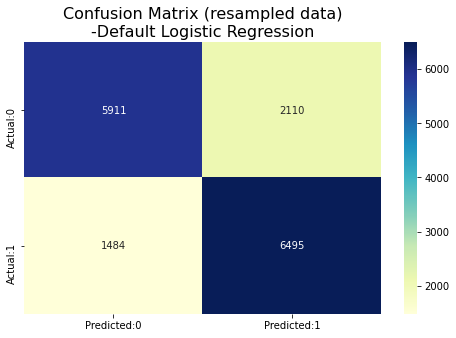

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_pred = CV_LR_clf.predict(X_test)

confmat = multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred,
                           labels=[1])

conf_matrix = pd.DataFrame(data=confmat[0],
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix (resampled data)\n-Default Logistic Regression", fontsize=16)
plt.show()

In [ ]:
acc3 = accuracy_score(y_test, y_pred)
acc3

0.775375

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import classification_report as cls_report

  
print('Classification Report: \n' + str(cls_report(y_test, y_pred)))

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      8021
           1       0.75      0.81      0.78      7979

    accuracy                           0.78     16000
   macro avg       0.78      0.78      0.78     16000
weighted avg       0.78      0.78      0.78     16000




##  Decision Tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
DT_grid = { 'min_samples_split': [5,10, 20, 30, 40], 
          'max_features': [None, 'log2', 'sqrt'],'criterion':['gini','entropy']}
CV_DT = GridSearchCV(DecisionTreeClassifier(random_state=42), DT_grid, verbose=1, cv=3)
CV_DT.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   51.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
print('Best Parameters: ', CV_DT.best_params_)

Best Parameters:  {'criterion': 'gini', 'max_features': None, 'min_samples_split': 5}


In [ ]:
%%time
from sklearn import tree
# Training step, on X_train with y_train
tree_clf = tree.DecisionTreeClassifier(min_samples_split = 5, criterion='gini')
tree_clf = tree_clf.fit(X_train,y_train)

tree_accuracy_train = tree_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (tree_accuracy_train*100))
tree_accuracy_test = tree_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (tree_accuracy_test*100))

Train Accuracy: 100.0%
Test Accuracy: 96.1%
CPU times: user 2.38 s, sys: 1.99 ms, total: 2.38 s
Wall time: 2.39 s


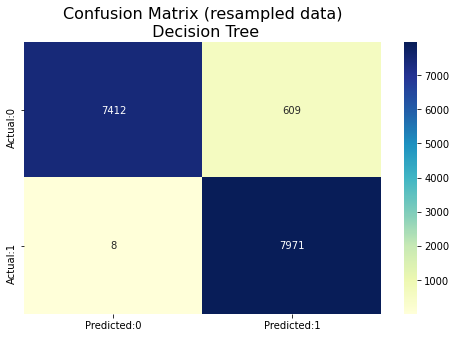

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import classification_report as cls_report

prediction = tree_clf.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=prediction)

conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix (resampled data)\n Decision Tree", fontsize=16)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import classification_report as cls_report

  
print('Classification Report: \n' + str(cls_report(y_test, prediction)))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      8021
           1       0.93      1.00      0.96      7979

    accuracy                           0.96     16000
   macro avg       0.96      0.96      0.96     16000
weighted avg       0.96      0.96      0.96     16000



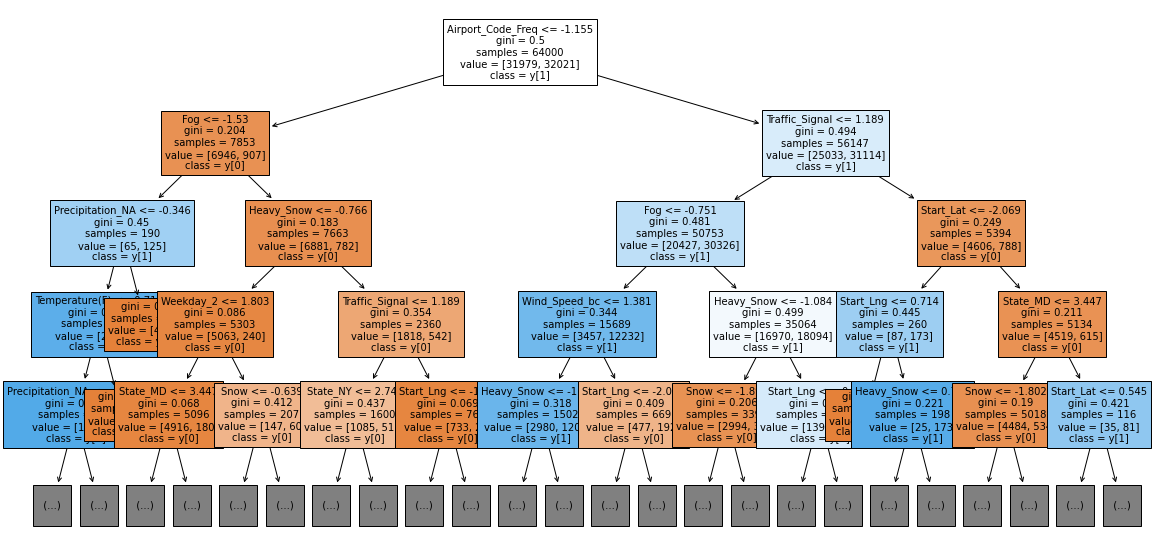

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(tree_clf, max_depth=4, fontsize=10,
               feature_names=df.drop('Severity4',axis =1).columns.to_list(),
               class_names = True, filled=True)
plt.show()


## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators'     : [30,40,50],
    'max_depth'        : [20,30,40]
}
CV_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,cv=4)
CV_clf.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
print('Best Parameters: ', CV_clf.best_params_)

Best Parameters:  {'max_depth': 40, 'n_estimators': 50}


Text(0.5, 1.0, 'Random Forest Classifier scores for different number of estimators')

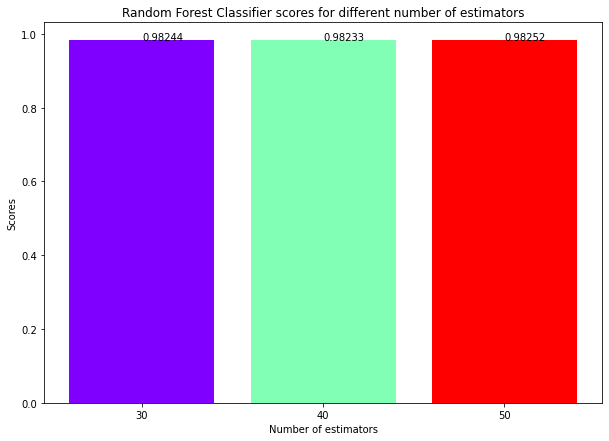

In [ ]:
from matplotlib.cm import rainbow
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier
rf_scores = []
estimators = [30,40, 50]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 42)
    rf_scores.append(cross_val_score(rf_classifier, X_train, y_train, cv=4, scoring='accuracy').mean())

plt.figure(figsize=(10,7))
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], round(rf_scores[i],5))
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(max_depth=40,n_estimators=50)
rf_clf.fit(X_train,y_train)

CPU times: user 8.48 s, sys: 17.9 ms, total: 8.5 s
Wall time: 8.51 s


In [ ]:
f = lambda x: 1 if x>=0.5 else 0
train_pred = np.array(list(map(f, rf_clf.predict(X_train))))
test_pred = np.array(list(map(f, rf_clf.predict(X_test))))

rf_train_accuracy = accuracy_score(y_train, train_pred)
print("Train Accuracy: %.1f%%"% (rf_train_accuracy*100))
rf_test_accuracy = accuracy_score(y_test, test_pred)
print("Test Accuracy: %.1f%%"% (rf_test_accuracy*100))

Train Accuracy: 100.0%
Test Accuracy: 98.4%


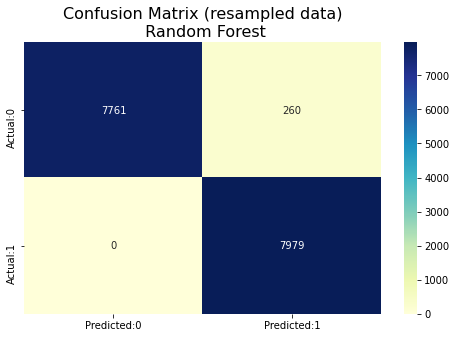

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=test_pred)

conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix (resampled data)\n Random Forest", fontsize=16)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import classification_report as cls_report

  
print('Classification Report: \n' + str(cls_report(y_test, test_pred)))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8021
           1       0.97      1.00      0.98      7979

    accuracy                           0.98     16000
   macro avg       0.98      0.98      0.98     16000
weighted avg       0.98      0.98      0.98     16000

